# Hot Hand effect dans les parties d’échecs en ligne

Ce notebook étudie l’existence d’un effet de *Hot Hand* dans les parties d’échecs en ligne :  
> le fait qu’une victoire augmente la probabilité de gagner la partie suivante.

L’analyse s’appuie sur des données de parties consécutives jouées par les mêmes joueurs, en tenant compte :
- du format de partie,
- du niveau des joueurs,
- de la proximité temporelle,
- et de contrôles statistiques (χ², régressions, simulations).

## Sommaire

- [Installation](#Installation)
- [Chargement et préparation des données](#chargement-et-préparation-des-données)
- [Dépendance brute entre résultats consécutifs](#dépendance-brute-entre-résultats-consécutifs)
- [Conclusion](#conclusion)

> 💡 **Note de lecture**  
> Le notebook peut être lu sans exécuter l’ensemble des cellules. Les résultats principaux sont commentés directement sous chaque graphique ou tableau.


## Installation

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
import os
import s3fs

## I. Récupération, préparation et prise en main des données 

### I.1 Fonctions utilitaires

In [18]:
# === CHARGEMENT DES DONNÉES ===
def load_games_from_s3(bucket, prefix, filename):
    endpoint = os.getenv("AWS_S3_ENDPOINT", "minio.lab.sspcloud.fr")
    s3_url = f"https://{endpoint}"
    storage_options = {"client_kwargs": {"endpoint_url": s3_url}}
    path = f"s3://{bucket}/{prefix}/{filename}"
    return pd.read_parquet(path, storage_options=storage_options)


# === NETTOYAGE DE BASE ===
def clean_games(df):
    if "game_id" in df.columns:
        df = df.drop_duplicates(subset=["user_id", "game_id"])
    else:
        df = df.drop_duplicates(subset=["user_id", "timestamp"])

    if "timestamp" not in df.columns and "timestamp_ms" in df.columns:
        df["timestamp"] = df["timestamp_ms"]

    df = df.sort_values(["user_id", "timestamp"])
    df = df[df["result"] != "Draw"].copy()

    df["win"] = (df["result"] == "Win").astype(int)
    df["win_next"] = df.groupby("user_id")["win"].shift(-1)

    return df


# === TRANSITIONS & TESTS ===
def transition_table(df, col="win"):
    table = pd.crosstab(df[col], df[f"{col}_next"])
    probs = table.div(table.sum(axis=1), axis=0)
    return table, probs


def chi2_pvalue(df, col_x, col_y):
    table = pd.crosstab(df[col_x], df[col_y])
    if table.shape == (2, 2):
        return chi2_contingency(table)[1]
    return np.nan


### I.2 Chargement et préparation des données

In [19]:
df_all = load_games_from_s3(
    bucket="tristant",
    prefix="diffusion",
    filename="dfs_games.parquet"
)

n_before = len(df_all)
df_all = clean_games(df_all)
n_after = len(df_all)

print(f"Nombre de parties supprimées (nuls et doublons) : {n_before - n_after}")
print(f"Nombre de parties restantes : {n_after}")

df_valid = df_all.dropna(subset=["win_next"])

Nombre de parties supprimées (nuls et doublons) : 1202
Nombre de parties restantes : 34428


Avant d’analyser l’effet Hot Hand, nous effectuons quelques étapes de préparation :

- Tri et déduplication : les parties sont triées par joueur et chronologiquement, et les doublons sont supprimés.

- Codage des résultats : victoire = 1, défaite = 0. Les parties nulles (Draws) sont supprimées pour simplifier le calcul du résultat suivant. Cette simplification n'est bien sûre pas optimale en termes d'analyse mais concerne moins de 5% des parties et simplifie grandement les analyses qui vont suivre.

>⚠️ Exemple : une séquence Win → Draw → Win est comptée comme Win → Win. Les streaks réels sont donc légèrement modifiés.

- Création de win_next : pour chaque joueur, cette colonne correspond au résultat de la partie suivante. Les dernières parties sans win_next sont retirées.

À ce stade, nous ne regardons pas encore les streaks exacts, mais seulement la dépendance entre résultats consécutifs.

### I.3 Prise en main des données

Avant de procéder aux analyses statistiques, nous présentons brièvement
les principales caractéristiques du jeu de données utilisé.

In [29]:
# Nombre total de parties, joueurs et transitions valides
n_games = len(df_all)
n_players = df_all["user_id"].nunique()
n_transitions = len(df_valid)

print(f"Nombre total de parties : {n_games}")
print(f"Nombre de joueurs uniques : {n_players}")
print(f"Nombre de transitions valides (win_next défini) : {n_transitions}")

# Répartition par format de partie
print("\nRépartition des parties par format :")
print(df_all["format_partie"].value_counts())

# Statistiques de rating
print("\nStatistiques des ratings des joueurs :")
print(df_all["rating"].describe())


Nombre total de parties : 34428
Nombre de joueurs uniques : 300
Nombre de transitions valides (win_next défini) : 34128

Répartition des parties par format :
format_partie
blitz        13990
rapid        11654
bullet        6376
classical     2408
Name: count, dtype: int64

Statistiques des ratings des joueurs :
count    34428.000000
mean      1203.411293
std        252.788698
min        400.000000
25%       1026.000000
50%       1216.000000
75%       1383.000000
max       2196.000000
Name: rating, dtype: float64


Le jeu de données contient un nombre suffisant de données pour l'analyse cependant il y a un nombre inférieur de parties bullet et surtout classical, on pourra garder cela en tête pour le reste de l'analyse.

Après nettoyage et suppression des parties nulles, on obtient un total
de `n_transitions` transitions consécutives exploitable, c’est-à-dire
des paires de parties successives jouées par un même individu.

Ces transitions constituent l’unité d’analyse de la suite du notebook.

In [21]:
games_per_player = df_all.groupby("user_id").size()

games_per_player.describe(percentiles=[0.1, 0.5, 0.9, 0.99])


count    300.000000
mean     114.760000
std       54.033457
min        1.000000
10%       56.900000
50%      117.000000
90%      182.100000
99%      232.000000
max      237.000000
dtype: float64

Le jeu de données comprend 34 428 parties jouées par 300 joueurs distincts,
soit en moyenne environ 115 parties par joueur (médiane : 117).

La distribution du nombre de parties par joueur est relativement homogène,
sans asymétrie marquée ni individus dominant excessivement l’échantillon
(nombre maximum de parties par joueur : 237).

Cette structure équilibrée constitue un cadre favorable à l’analyse des
dépendances entre résultats consécutifs, en limitant le risque que les
résultats soient entraînés par un petit nombre de joueurs très actifs.

## II. Dépendances brutes

### II.1 Dépendance brute entre résultats consécutifs

Nous comparons la probabilité de gagner la partie N+1 selon que la partie N ait été gagnée ou perdue.


In [22]:
table, probs = transition_table(df_valid)
p_value = chi2_pvalue(df_valid, "win", "win_next")

probs, p_value


(win_next       0.0       1.0
 win                         
 0         0.547975  0.452025
 1         0.506477  0.493523,
 np.float64(1.943536816565054e-14))

On observe une probabilité de victoire à N+1 plus élevée après une victoire qu’après une défaite.

Le test du χ² rejette très fortement l’hypothèse d’indépendance entre les résultats consécutifs (p-value < 0,01).

Cependant, cette dépendance brute peut toutefois s’expliquer par des facteurs structurels
(niveau relatif des joueurs, rematchs, sessions de jeu) et ne constitue pas encore une preuve d’un effet *Hot Hand*.


### II.2 Dépendance brute selon le format de partie

Nous analysons maintenant si la probabilité de gagner la partie suivante dépend du résultat précédent, **en distinguant les formats de partie** (bullet, blitz, rapid, classical).

> On compare P(Victoire N+1 | Victoire N) et P(Victoire N+1 | Défaite N) pour chaque type de format.


#### II.2.A Probabilité de victoire à N+1 selon le résultat précédent et calcul de la p-value

In [26]:
# Probabilités conditionnelles par format
probs_by_format = df_all.groupby("format_partie").apply(
    lambda x: x.groupby("win")["win_next"].mean()
)
print("Probabilités de victoire à N+1 selon le résultat précédent :")
print(probs_by_format)

# Test χ² par format
print("\nTest d'indépendance χ² par format :")
for fmt, df_fmt in df_all.groupby("format_partie"):
    p_val = chi2_pvalue(df_fmt, "win", "win_next")
    print(f"Format {fmt} - p-value χ² : {p_val:.3e}")


Probabilités de victoire à N+1 selon le résultat précédent :
win                   0         1
format_partie                    
blitz          0.475278  0.496556
bullet         0.405746  0.485799
classical      0.434576  0.505245
rapid          0.456332  0.491219

Test d'indépendance χ² par format :
Format blitz - p-value χ² : 1.313e-02
Format bullet - p-value χ² : 2.338e-10
Format classical - p-value χ² : 6.088e-04
Format rapid - p-value χ² : 1.862e-04


/tmp/ipykernel_51472/3269007915.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  probs_by_format = df_all.groupby("format_partie").apply(


Même quand on affine la lecture (selon les types de parties) : l'analyse permet de réfuter avec quasi-certitude l'hypothèse d'indépendance entre résultat du match N et du match N+1. Le résultat est d'autant plus significatif pour les parties "courtes" de type bullet.

Ce qui est cohérent avec l'intuition : ces parties courtes sont susceptibles d'être influencés par des facteurs psychologiques de confiance en soi puisqu'elles sont souvent faites à la suite les unes des autres (cf partie de l'analyse avec affinement pour tenir compte de la proximité temporelle).

#### II.2.B Visualisation

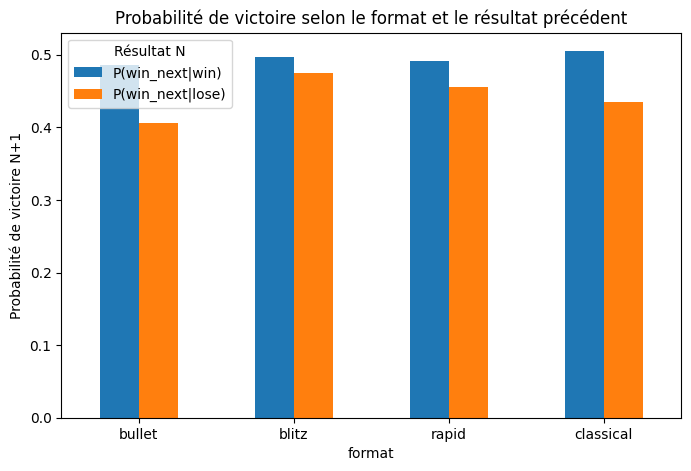

In [ ]:
format_order = ["bullet", "blitz", "rapid", "classical"]

# Préparer le DataFrame pour le graphique
prob_df = []
for fmt in format_order:
    if fmt in probs_by_format.index:
        prob_df.append({
            "format": fmt,
            "P(win_next|win)": probs_by_format.loc[fmt, 1],
            "P(win_next|lose)": probs_by_format.loc[fmt, 0]
        })

prob_df = pd.DataFrame(prob_df)

# Graphique simple
prob_df.set_index("format")[["P(win_next|win)", "P(win_next|lose)"]].plot(
    kind="bar", figsize=(8,5), color=["#1f77b4", "#ff7f0e"]
)
plt.ylabel("Probabilité de victoire N+1")
plt.title("Probabilité de victoire selon le format et le résultat précédent")
plt.xticks(rotation=0)
plt.legend(title="Résultat N")
plt.show()

### II.3 Dependance brute selon le niveau du joueur

Nous analysons maintenant si la probabilité de gagner la partie suivante dépend du résultat précédent, **en distinguant le niveau du joueur de partie** que nous classerons dans différents *rating bin*.

> On compare P(Victoire N+1 | Victoire N) et P(Victoire N+1 | Défaite N) pour chaque *rating bin*.



In [30]:
# --- Création des tranches de niveau (octiles) ---
# duplicates='drop' gère le cas où trop de joueurs ont exactement le même Elo
df_all['rating_bin'] = pd.qcut(df_all['rating'], q=8, duplicates='drop')

# Vérification rapide
df_all['rating_bin'].value_counts().sort_index()


rating_bin
(399.999, 914.0]    4312
(914.0, 1026.0]     4298
(1026.0, 1118.0]    4341
(1118.0, 1216.0]    4331
(1216.0, 1290.0]    4257
(1290.0, 1383.0]    4300
(1383.0, 1490.0]    4312
(1490.0, 2196.0]    4277
Name: count, dtype: int64

#### II.3.A Probabilité de victoire à N+1 selon le résultat précédent

On calcule la probabilité qu'un joueur gagne la partie suivante en fonction de s'il a gagné ou perdu la précédente, pour chaque tranche de niveau.


In [37]:
# Filtrer les parties valides
df_valid = df_all.dropna(subset=["win_next"])

# --- Probabilités conditionnelles par tranche de rating ---
df_plot = (
    df_valid.groupby(["rating_bin", "win"], observed=True)["win_next"]
            .mean()
            .reset_index()
)
df_plot["win_label"] = df_plot["win"].map({0: "Défaite précédente", 1: "Victoire précédente"})

# --- Calcul des p-values χ² par tranche de rating ---
p_values_rating = {}
for bin_label, df_bin in df_valid.groupby("rating_bin"):
    table = pd.crosstab(df_bin["win"], df_bin["win_next"])
    if table.shape == (2, 2):
        _, p_val, _, _ = chi2_contingency(table)
        p_values_rating[bin_label] = p_val
    else:
        p_values_rating[bin_label] = np.nan

# Affichage rapide
print("Probabilités de victoire à N+1 par tranche de rating :")
print(df_plot.pivot(index="rating_bin", columns="win_label", values="win_next"))

print("\nP-values χ² par tranche de rating :")
for bin_label, p_val in p_values_rating.items():
    print(f"{bin_label}: {p_val:.3e}")


Probabilités de victoire à N+1 par tranche de rating :
win_label         Défaite précédente  Victoire précédente
rating_bin                                               
(399.999, 914.0]            0.426752             0.486430
(914.0, 1026.0]             0.472121             0.500000
(1026.0, 1118.0]            0.475270             0.490602
(1118.0, 1216.0]            0.458576             0.501947
(1216.0, 1290.0]            0.462066             0.497292
(1290.0, 1383.0]            0.460062             0.490128
(1383.0, 1490.0]            0.466305             0.506059
(1490.0, 2196.0]            0.401727             0.472995

P-values χ² par tranche de rating :
(399.999, 914.0]: 1.109e-04
(914.0, 1026.0]: 7.413e-02
(1026.0, 1118.0]: 3.297e-01
(1118.0, 1216.0]: 4.968e-03
(1216.0, 1290.0]: 2.397e-02
(1290.0, 1383.0]: 5.319e-02
(1383.0, 1490.0]: 1.023e-02
(1490.0, 2196.0]: 3.843e-06


/tmp/ipykernel_51472/278936193.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin_label, df_bin in df_valid.groupby("rating_bin"):


On observe que la probabilité de gagner la partie suivante est généralement plus élevée après une victoire que après une défaite, quelle que soit la tranche de niveau.

Les différences sont particulièrement marquées dans les tranches très basses (399.999, 914] et très hautes (1490, 2196].

Les p-values du test χ² confirment que l’indépendance entre le résultat précédent et le résultat suivant peut être rejetée de manière significative dans la plupart des tranches (p < 0,05).

#### II.3.B Visualisation

On trace un graphique en barres montrant la probabilité de victoire à N+1 selon le résultat précédent pour chaque tranche de niveau.


/tmp/ipykernel_51472/3990906670.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  probs_by_rating = df_all.groupby("rating_bin").apply(
/tmp/ipykernel_51472/3990906670.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  probs_by_rating = df_all.groupby("rating_bin").apply(


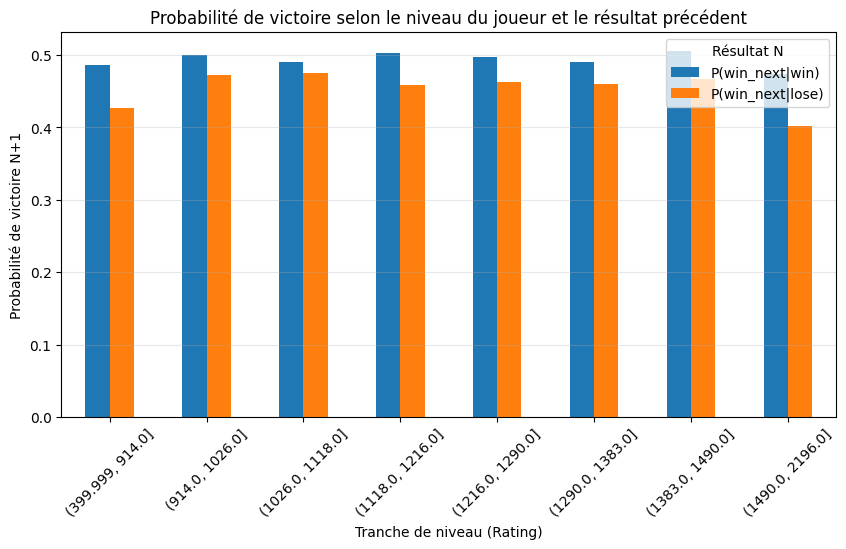

In [36]:
# --- Probabilités conditionnelles par tranche de rating ---
probs_by_rating = df_all.groupby("rating_bin").apply(
    lambda x: x.groupby("win")["win_next"].mean()
)

# Préparer le DataFrame pour le graphique
rating_labels = [str(interval) for interval in probs_by_rating.index]
prob_df = []
for i, r in enumerate(probs_by_rating.index):
    prob_df.append({
        "rating_bin": rating_labels[i],
        "P(win_next|win)": probs_by_rating.loc[r, 1],
        "P(win_next|lose)": probs_by_rating.loc[r, 0]
    })

prob_df = pd.DataFrame(prob_df)

# Graphique avec la même DA que pour les formats
prob_df.set_index("rating_bin")[["P(win_next|win)", "P(win_next|lose)"]].plot(
    kind="bar", figsize=(10,5), color=["#1f77b4", "#ff7f0e"]
)
plt.ylabel("Probabilité de victoire N+1")
plt.xlabel("Tranche de niveau (Rating)")
plt.title("Probabilité de victoire selon le niveau du joueur et le résultat précédent")
plt.xticks(rotation=45)
plt.legend(title="Résultat N")
plt.grid(axis='y', alpha=0.3)
plt.show()


Même au sein des différentes tranches de niveau, on observe que la probabilité de gagner la partie suivante est plus élevée après une victoire précédente.  

## III. Proximité temporelle et sessions de jeu

L’effet *Hot Hand* est, par définition, un phénomène **local dans le temps** :  
il suppose que les performances récentes influencent les suivantes **à court terme**.

Dans les analyses précédentes, deux parties consécutives peuvent toutefois être séparées
de quelques secondes… ou de plusieurs jours. Traiter ces situations comme équivalentes
peut créer une dépendance artificielle ou, au contraire, diluer un effet réel.

L’objectif de cette section est donc de **restreindre l’analyse aux parties réellement
consécutives**, jouées dans une même session de jeu.


### III.1 Définition d’une session de jeu

Nous définissons une *session de jeu* comme une suite de parties jouées par un même joueur,
séparées par **au plus 30 minutes** entre deux parties consécutives.

Ce seuil constitue un compromis :
- suffisamment court pour capturer des enchaînements intentionnels de parties ;
- suffisamment long pour inclure les pauses naturelles (analyse rapide, attente d’adversaire).

L’analyse repose avant tout sur une **comparaison avant / après filtrage temporel** :
le choix exact du seuil n’est donc pas déterminant.


In [41]:
# Conversion du timestamp en datetime
df_all["date"] = pd.to_datetime(df_all["timestamp"], unit="ms")

# Tri par joueur et par date
df_all = df_all.sort_values(["user_id", "date"]).reset_index(drop=True)

# Écart temporel entre parties consécutives (en minutes)
df_all["delta_minutes"] = (
    df_all.groupby("user_id")["date"]
          .diff()
          .dt.total_seconds() / 60
)

# Définition du seuil de session
SESSION_GAP = 30  # minutes

# Nouvelle session si la pause dépasse le seuil
df_all["new_session"] = (
    (df_all["delta_minutes"] > SESSION_GAP) | (df_all["delta_minutes"].isna())
)

# Identifiant de session
df_all["session_id"] = df_all.groupby("user_id")["new_session"].cumsum()


Chaque partie est maintenant associée à une **session de jeu**.
Nous pouvons dès lors restreindre l’analyse aux transitions entre parties
jouées dans une même session.


In [45]:
# Création de win_next limité aux parties intra-session
def compute_win_next_session(df, max_gap_minutes=30):
    df = df.copy()
    df["win_next_session"] = df["win"].shift(-1)
    df["delta_next"] = (
        df["date"].shift(-1) - df["date"]
    ).dt.total_seconds() / 60
    
    df.loc[
        df["delta_next"] > max_gap_minutes,
        "win_next_session"
    ] = pd.NA
    
    return df

df_all = (
    df_all.groupby("user_id")
          .apply(compute_win_next_session, max_gap_minutes=SESSION_GAP)
          .reset_index(drop=True)
)

# Transitions valides intra-session
df_session = df_all.dropna(subset=["win_next_session"]).copy()

print(f"Nombre de transitions brutes : {len(df_brut)}")
print(f"Nombre de transitions intra-session : {len(df_session)}")


Nombre de transitions brutes : 34128
Nombre de transitions intra-session : 18778


/tmp/ipykernel_51472/2823205171.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_win_next_session, max_gap_minutes=SESSION_GAP)


### III.2 Comparaison : dépendance brute vs dépendance intra-session

Nous comparons maintenant la dépendance entre les résultats consécutifs :
- **sans contrainte temporelle** ;
- **en restreignant aux parties intra-session**.


In [44]:
# --- Dépendance brute (sans filtrage temporel) ---
df_all = df_all.sort_values(["user_id", "date"]).reset_index(drop=True)
df_all["win_next_brut"] = df_all.groupby("user_id")["win"].shift(-1)

# --- Dépendance brute (sans filtrage temporel) ---
df_brut = df_all.dropna(subset=["win_next_brut"])

table_brut = pd.crosstab(df_brut["win"], df_brut["win_next_brut"])
_, p_value_brut, _, _ = chi2_contingency(table_brut)

# --- Dépendance intra-session ---
table_session = pd.crosstab(df_session["win"], df_session["win_next_session"])
_, p_value_session, _, _ = chi2_contingency(table_session)

# Résumé comparatif
summary_time = pd.DataFrame({
    "Cadre d'analyse": [
        "Sans contrainte temporelle",
        "Intra-session (≤ 30 minutes)"
    ],
    "p-value χ²": [
        p_value_brut,
        p_value_session
    ]
})

summary_time


,Cadre d'analyse,p-value χ²
0,Sans contrainte temporelle,1.943537e-14
1,Intra-session (≤ 30 minutes),4.627521e-12


### III.3 Lecture des résultats

La dépendance entre le résultat d’une partie et celui de la partie suivante
reste hautement significative lorsque l’on restreint l’analyse aux parties
jouées dans une même session (≤ 30 minutes).

Ce résultat indique que la dépendance observée précédemment ne provient pas
uniquement de parties consécutives éloignées dans le temps, mais qu’elle
s’exprime également au sein de séquences de jeu continues.

Le filtrage temporel ne vise pas à faire disparaître l’effet, mais à vérifier
qu’il persiste dans un cadre compatible avec l’hypothèse d’un effet *Hot Hand*
local dans le temps.



## IV. Mémoire intra-session : analyse markovienne

Dans la section précédente, nous avons montré que la dépendance entre résultats consécutifs
persiste lorsque l’on se restreint à des parties jouées **dans une même session** (≤ 30 minutes).

Nous testons maintenant une question plus précise :

> La dépendance intra-session est-elle **entièrement capturée par le dernier résultat** (Markov d’ordre 1),
> ou existe-t-il une **mémoire plus longue** (Markov d’ordre 2), c.-à-d. un effet cumulatif ?

Formellement : On compare deux hypothèses de mémoire :

- **Ordre 1** : le résultat à *t* dépend uniquement du match précédent (*t−1*).
- **Ordre 2** : le résultat à *t* dépend des deux matchs précédents (*t−1* et *t−2*)

Dans toute cette section, l’analyse est effectuée **uniquement sur les transitions intra-session**.



In [46]:
# Sécurité : tri cohérent
df_all = df_all.sort_values(["user_id", "date"]).reset_index(drop=True)

# On conserve uniquement les parties appartenant à des sessions (définies en II)
# et on travaille intra-session en groupant par (user_id, session_id).
df_intra = df_all.dropna(subset=["session_id"]).copy()

# Construction des lags DANS chaque session
df_intra["win_lag1"] = df_intra.groupby(["user_id", "session_id"])["win"].shift(1)
df_intra["win_lag2"] = df_intra.groupby(["user_id", "session_id"])["win"].shift(2)

# Dataset Markov intra-session : on garde les lignes où lag1 & lag2 existent
df_mk_sess = df_intra.dropna(subset=["win_lag1", "win_lag2", "win"]).copy()
df_mk_sess[["win_lag1", "win_lag2"]] = df_mk_sess[["win_lag1", "win_lag2"]].astype(int)

print(f"Nombre d'observations Markov intra-session (lags définis) : {len(df_mk_sess)}")

Nombre d'observations Markov intra-session (lags définis) : 12033


### IV.1 Probabilités conditionnelles (Markov ordre 2)

On regarde si le résultat d’une partie dépend des **deux résultats précédents**.

Pour chaque partie *t*, on code l’“historique” des deux matchs précédents (*t−2*, *t−1*) parmi 4 états possibles :
- `00` : défaite puis défaite
- `01` : défaite puis victoire
- `10` : victoire puis défaite
- `11` : victoire puis victoire

Pour chacun de ces états, on calcule ensuite la proportion de victoires à *t* :
**P(victoire à t | état passé)**.

> ⚠️ Cette étape est **descriptive** : elle sert à visualiser une éventuelle accumulation.
> La significativité statistique sera testée juste après en comparant l’ordre 1 et l’ordre 2.


In [47]:
df_mk_sess["state2"] = df_mk_sess["win_lag2"].astype(str) + df_mk_sess["win_lag1"].astype(str)

p_state2 = df_mk_sess.groupby("state2")["win"].mean().reindex(["00", "01", "10", "11"])
n_state2 = df_mk_sess["state2"].value_counts().reindex(["00", "01", "10", "11"])

markov_table = pd.DataFrame({"P(win | state)": p_state2, "n": n_state2})
markov_table


,P(win | state),n
state2,,
00,0.430349,3295
01,0.482624,2820
10,0.471591,2816
11,0.523856,3102


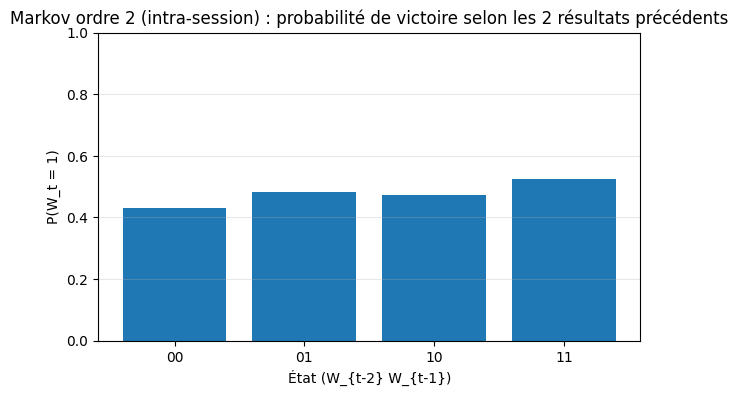

In [48]:
plt.figure(figsize=(7, 4))
plt.bar(p_state2.index, p_state2.values)
plt.ylim(0, 1)
plt.xlabel("État (W_{t-2} W_{t-1})")
plt.ylabel("P(W_t = 1)")
plt.title("Markov ordre 2 (intra-session) : probabilité de victoire selon les 2 résultats précédents")
plt.grid(axis="y", alpha=0.3)
plt.show()


La probabilité de victoire augmente avec un historique plus favorable : minimale après `00`, intermédiaire après `01`/`10`, maximale après `11`. Cela est conforme à nos attentes cependant ces résultats restent descriptifs. La section suivante teste formellement si l’ordre 2 apporte un gain par rapport à l’ordre 1.


### IV.2 Test formel : Markov d’ordre 1 vs Markov d’ordre 2 (LR test)

Nous comparons deux modèles logistiques emboîtés :

- **M1 (ordre 1)** : la probabilité de gagner dépend uniquement du résultat précédent (`win_lag1`).
- **M2 (ordre 2)** : la probabilité de gagner dépend du résultat précédent (`win_lag1`) *et* de l’avant-dernier (`win_lag2`).

Si le modèle M2 améliore significativement l’ajustement, cela signifie que le résultat à *t−2*
apporte une information au-delà du seul résultat à *t−1* : il existe donc une mémoire
plus longue qu’un match.

Nous reportons également les critères **AIC** et **BIC**, qui pénalisent la complexité du modèle.


In [56]:
def fit_logit(df, y_col, x_cols):
    X = sm.add_constant(df[x_cols])
    y = df[y_col]
    return sm.Logit(y, X).fit(disp=0)

m1 = fit_logit(df_mk_sess, y_col="win", x_cols=["win_lag1"])
m2 = fit_logit(df_mk_sess, y_col="win", x_cols=["win_lag1", "win_lag2"])

LR = 2 * (m2.llf - m1.llf)
df_diff = int(m2.df_model - m1.df_model)
p_lr = chi2.sf(LR, df_diff)

summary_models = pd.DataFrame({
    "Model": ["Order 1", "Order 2"],
    "LogLik": [m1.llf, m2.llf],
    "AIC": [m1.aic, m2.aic],
    "BIC": [m1.bic, m2.bic],
})
summary_models, {"LR": LR, "df": df_diff, "p_value": p_lr}


(     Model       LogLik           AIC           BIC
 0  Order 1 -8309.025006  16622.050013  16636.840829
 1  Order 2 -8298.783216  16603.566431  16625.752656,
 {'LR': np.float64(20.48358166748585),
  'df': 1,
  'p_value': np.float64(6.014495740220719e-06)})

### IV.3 Interprétation

Le test du rapport de vraisemblance (LR) indique que le modèle d’ordre 2 apporte un gain
significatif par rapport au modèle d’ordre 1 (LR = 20.48, p-value ≈ 6.0e-06).

Ce résultat signifie que, même en connaissant le résultat du match précédent (*t−1*),
le résultat de l’avant-dernier match (*t−2*) contient encore de l’information pour prédire
l’issue de la partie courante. Autrement dit, la dynamique des résultats au sein des sessions
ne se résume pas à une mémoire d’un seul match.

Les critères d’information vont dans le même sens : AIC et BIC diminuent lorsque l’on passe
de l’ordre 1 à l’ordre 2, malgré la pénalisation liée au paramètre supplémentaire.


### IV. Conclusion de section

Au sein des sessions de jeu (parties rapprochées dans le temps), les résultats présentent
une **mémoire d’ordre 2** : les deux matchs précédents contribuent à expliquer la probabilité
de victoire, au-delà du seul dernier résultat.

Cette évidence statistique caractérise une dépendance temporelle plus longue qu’un match,
compatible avec l’idée d’un effet *Hot Hand* cumulatif à court terme.

La suite du notebook introduit des contrôles (niveau du joueur, couleur, fatigue/session)
afin d’évaluer dans quelle mesure cette mémoire peut être expliquée par des facteurs alternatifs.


Création des variables d'analyse (Fatigue, Couleur, Historique)...


/tmp/ipykernel_51472/4293438249.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="is_white", y="win", data=df_all, ax=axes[0], palette="coolwarm", errorbar=None)
/tmp/ipykernel_51472/4293438249.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["Noirs", "Blancs"])


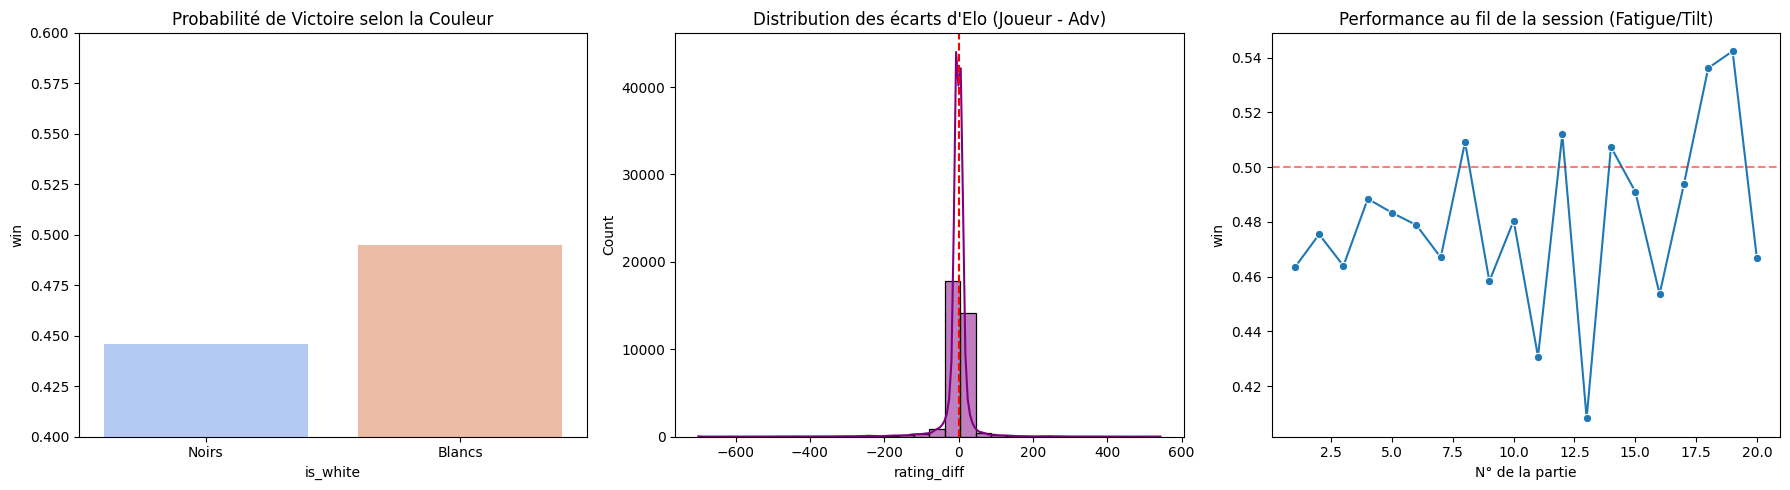


=== CHAÎNES DE MARKOV : EFFET MÉMOIRE ===


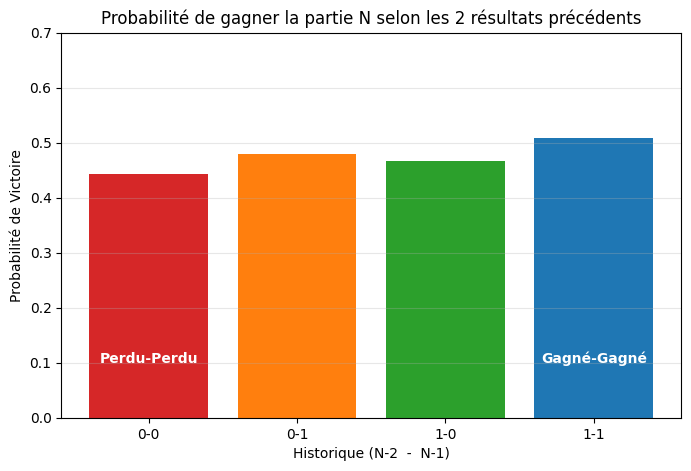

Lecture : Si la barre de droite (1-1) est plus haute que les autres, le 'Hot Hand' s'accumule.


In [38]:
# --- 1. PRÉPARATION DES VARIABLES ADDITIONNELLES ---
print("Création des variables d'analyse (Fatigue, Couleur, Historique)...")
df_all = df_all.sort_values(['user_id', 'timestamp'])

# a) Résultat précédent (N-1) et (N-2)
df_all['win_prev'] = df_all.groupby('user_id')['win'].shift(1)
df_all['win_prev_2'] = df_all.groupby('user_id')['win'].shift(2)

# b) Couleur (Blancs = 1)
if 'color' in df_all.columns:
    df_all['is_white'] = (df_all['color'] == 'white').astype(int)
else:
    df_all['is_white'] = np.nan

# c) Fatigue / Session de jeu
# On considère une nouvelle session si > 30 min de pause
df_all['time_diff'] = df_all.groupby('user_id')['timestamp'].diff() / (1000 * 60) # minutes
df_all['new_session'] = (df_all['time_diff'] > 30) | (df_all['time_diff'].isna())
df_all['session_id'] = df_all.groupby('user_id')['new_session'].cumsum()
df_all['game_in_session'] = df_all.groupby(['user_id', 'session_id']).cumcount() + 1


# --- 2. VISUALISATIONS DESCRIPTIVES ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Graph A : Avantage des Blancs
if df_all['is_white'].notna().any():
    sns.barplot(x="is_white", y="win", data=df_all, ax=axes[0], palette="coolwarm", errorbar=None)
    axes[0].set_xticklabels(["Noirs", "Blancs"])
    axes[0].set_title("Probabilité de Victoire selon la Couleur")
    axes[0].set_ylim(0.4, 0.6)

# Graph B : Distribution des écarts Elo
if "rating_diff" in df_all.columns:
    sns.histplot(df_all["rating_diff"], bins=30, kde=True, ax=axes[1], color="purple")
    axes[1].set_title("Distribution des écarts d'Elo (Joueur - Adv)")
    axes[1].axvline(0, color='red', linestyle='--')

# Graph C : Fatigue (Win rate selon le n° de partie dans la session)
# On regarde les sessions longues (>10 parties)
long_sessions = df_all[df_all['game_in_session'] <= 20]
sns.lineplot(x="game_in_session", y="win", data=long_sessions, ax=axes[2], marker="o", errorbar=None)
axes[2].set_title("Performance au fil de la session (Fatigue/Tilt)")
axes[2].set_xlabel("N° de la partie")
axes[2].axhline(0.5, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


# --- 3. ANALYSE MARKOVIENNE (ORDRE 2) ---
print("\n=== CHAÎNES DE MARKOV : EFFET MÉMOIRE ===")
# On regarde l'impact de l'historique (N-2, N-1) sur la partie N
df_markov = df_all.dropna(subset=['win_prev_2', 'win_prev', 'win']).copy()
df_markov['etat_passe'] = (
    df_markov['win_prev_2'].astype(int).astype(str) + "-" + 
    df_markov['win_prev'].astype(int).astype(str)
)

probs_ordre2 = df_markov.groupby('etat_passe')['win'].mean().sort_index()

plt.figure(figsize=(8, 5))
bars = plt.bar(probs_ordre2.index, probs_ordre2.values, color=['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4'])
plt.title("Probabilité de gagner la partie N selon les 2 résultats précédents")
plt.xlabel("Historique (N-2  -  N-1)")
plt.ylabel("Probabilité de Victoire")
plt.ylim(0, 0.7)
plt.grid(axis='y', alpha=0.3)

# Légende pour comprendre
plt.text(0, 0.1, "Perdu-Perdu", ha='center', color='white', fontweight='bold')
plt.text(3, 0.1, "Gagné-Gagné", ha='center', color='white', fontweight='bold')

plt.show()
print("Lecture : Si la barre de droite (1-1) est plus haute que les autres, le 'Hot Hand' s'accumule.")

# Un joueur qui gagne refait-il la même ouverture ?

In [ ]:
# --- 1️. Créer la colonne "same_opening_next" ---
df_all = df_all.sort_values(["user_id", "timestamp"]).reset_index(drop=True)
df_all["same_opening_next"] = (
    df_all.groupby("user_id")["opening_name"].shift(-1) == df_all["opening_name"]
).astype(int)

# Filtrer lignes valides (où on peut calculer next opening)
df_valid = df_all.dropna(subset=["same_opening_next"])

# --- 2️. Probabilités globales ---
prob_same_by_result = df_valid.groupby("win")["same_opening_next"].mean()
print("Probabilité de rejouer la même ouverture selon résultat N :")
print(prob_same_by_result)

# --- 3️. Test χ² global ---
table_global = pd.crosstab(df_valid["win"], df_valid["same_opening_next"])
chi2, p_value, _, _ = chi2_contingency(table_global)
print("\nTest χ² global :")
print(table_global)
print("p-value :", p_value)

# --- 4️. Analyse par type de partie ---
results_by_format = {}
for fmt, df_fmt in df_valid.groupby("format_partie"):
    table_fmt = pd.crosstab(df_fmt["win"], df_fmt["same_opening_next"])
    if table_fmt.shape == (2,2):
        chi2, p, _, _ = chi2_contingency(table_fmt)
        prob_fmt = df_fmt.groupby("win")["same_opening_next"].mean()
        results_by_format[fmt] = {
            "table": table_fmt,
            "probabilities": prob_fmt,
            "p_value": p
        }

# Afficher les résultats par format
for fmt, res in results_by_format.items():
    print(f"\nFormat : {fmt}")
    print("Table de contingence :\n", res["table"])
    print("Probabilités :", res["probabilities"].to_dict())
    print("p-value :", res["p_value"])

Probabilité de rejouer la même ouverture selon résultat N :
win
0    0.133629
1    0.146625
Name: same_opening_next, dtype: float64

Test χ² global :
same_opening_next      0     1
win                           
0                  15800  2437
1                  13817  2374
p-value : 0.0005492451867909473

Format : blitz
Table de contingence :
 same_opening_next     0    1
win                         
0                  6257  961
1                  5829  943
Probabilités : {0: 0.13313937378775284, 1: 0.13924985233313644}
p-value : 0.3036256684417361

Format : bullet
Table de contingence :
 same_opening_next     0    1
win                         
0                  3179  481
1                  2283  433
Probabilités : {0: 0.13142076502732242, 1: 0.15942562592047127}
p-value : 0.0018126027109408374

Format : classical
Table de contingence :
 same_opening_next     0    1
win                         
0                  1103  160
1                   983  162
Probabilités : {0: 0.12668250197

On remarque que la p-value du test "Il y a dépendance entre gain à la partie N et ouverture rejouée en N+1" est plus significative pour les parties courtes, signe que les joueurs joue davantage à l'instinct.

# Retraitement de l'analyse principale 
On cherche à n'étudier que des streaks de parties qui se suivent réellement (c'est-à-dire pas seulement des parties consécutives - et potentiellement espacées de plusieurs jours-, mais rapprochées dans le temps).

In [3]:
# S'assurer que timestamp est en datetime
df_all["date"] = pd.to_datetime(df_all["timestamp"], unit='ms')

# Trier par joueur et date
df_all = df_all.sort_values(["user_id", "date"]).reset_index(drop=True)

# Calculer delta_hours entre parties consécutives
df_all["delta_hours"] = df_all.groupby("user_id")["date"].diff().dt.total_seconds() / 3600

# Fonction pour calculer les streaks avec durée maximale paramétrable et format_partie
def streaks_with_time_by_format(df, max_gap_hours):
    streaks = []
    if df.empty:
        return streaks
    
    prev_win = df.iloc[0]["win"]
    prev_time = df.iloc[0]["date"]
    prev_format = df.iloc[0]["format_partie"]
    count = 1
    
    for idx, row in df.iloc[1:].iterrows():
        delta = (row["date"] - prev_time).total_seconds() / 3600
        if (row["win"] == prev_win) and (delta <= max_gap_hours) and (row["format_partie"] == prev_format):
            count += 1
        else:
            if count >= 2:
                streaks.append((prev_win, prev_format, count))
            count = 1
            prev_win = row["win"]
            prev_format = row["format_partie"]
        prev_time = row["date"]
    
    # Vérifier le dernier streak
    if count >= 2:
        streaks.append((prev_win, prev_format, count))
        
    return streaks

# Durée maximale entre les parties, fixée à 30 min
max_gap_hours = 0.5

# Appliquer à tous les joueurs
all_streaks = []
for user, df_user in df_all.groupby("user_id"):
    streaks = streaks_with_time_by_format(df_user, max_gap_hours=max_gap_hours)
    all_streaks.extend(streaks)

# Convertir en DataFrame
streak_df = pd.DataFrame(all_streaks, columns=["win", "format_partie", "length"])

# Tableau descriptif par type de partie et résultat
table_by_format = streak_df.groupby(["format_partie", "win"])["length"].describe()

print("\nStatistiques des streaks (longueur >= 2) par type de partie et résultat :")
print(table_by_format)

NameError: name 'df_all' is not defined

C'est cohérent avec l'intuition, on pourrait penser qu'une suite de défaites incite le joueur à se décourager et arrêter de jouer.
Les statistiques sont aussi cohérentes : on observe une longueur maximale de streak plus courte pour les parties de type long comme classical.

In [ ]:
# Trier par joueur et date
df_all = df_all.sort_values(["user_id", "date"]).reset_index(drop=True)

# Calculer delta_hours entre parties consécutives
df_all["delta_hours"] = df_all.groupby("user_id")["date"].diff().dt.total_seconds() / 3600

# Créer win_next pour toutes les parties (sans limite de temps)
df_all["win_next_brut"] = df_all.groupby("user_id")["win"].shift(-1)

# Demander la limite de temps pour "streak rapide"
max_gap_hours = 0.5

# Créer win_next limité par delta_hours
def compute_win_next_limited(df, max_gap_hours):
    df = df.copy()
    df["win_next_limited"] = df["win"].shift(-1)
    df["delta_next_hours"] = df["date"].shift(-1) - df["date"]
    df["delta_next_hours"] = df["delta_next_hours"].dt.total_seconds() / 3600
    df.loc[df["delta_next_hours"] > max_gap_hours, "win_next_limited"] = pd.NA
    return df

df_all = df_all.groupby("user_id").apply(lambda x: compute_win_next_limited(x, max_gap_hours)).reset_index(drop=True)

# Supprimer les NaN
df_clean_brut = df_all.dropna(subset=["win_next_brut"])
df_clean_limited = df_all.dropna(subset=["win_next_limited"])

# Stocker les résultats
results_by_format = []

for fmt in df_all["format_partie"].unique():
    # Table brute
    df_fmt_brut = df_clean_brut[df_clean_brut["format_partie"] == fmt]
    table_brut = pd.crosstab(df_fmt_brut["win"], df_fmt_brut["win_next_brut"])
    _, p_value_brut, _, _ = chi2_contingency(table_brut)

    # Table limitée
    df_fmt_lim = df_clean_limited[df_clean_limited["format_partie"] == fmt]
    table_lim = pd.crosstab(df_fmt_lim["win"], df_fmt_lim["win_next_limited"])
    _, p_value_limited, _, _ = chi2_contingency(table_lim)

    results_by_format.append({
        "format_partie": fmt,
        "p_value_brute": p_value_brut,
        "p_value_limited": p_value_limited
    })

# Résumé
summary_df = pd.DataFrame(results_by_format)
print("\nComparaison p-values par type de partie (brut vs limité par delta_hours) :")
print(summary_df)


Comparaison p-values par type de partie (brut vs limité par delta_hours) :
  format_partie  p_value_brute  p_value_limited
0         blitz   1.312755e-02     1.544598e-02
1         rapid   1.861755e-04     4.890625e-05
2        bullet   2.338387e-10     6.952840e-09
3     classical   6.087753e-04     3.829329e-03


/tmp/ipykernel_25940/80356230.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_all = df_all.groupby("user_id").apply(lambda x: compute_win_next_limited(x, max_gap_hours)).reset_index(drop=True)


# Mise en oeuvre de régressions

Préparation des données : 
Création des variables décalées (lags) et gestion du problème "Opponent Rating".

Note importante : Votre dataset actuel ne contient pas l'Elo de l'adversaire (seulement celui du joueur). On ne peut donc pas calculer le ScoreExpected exact avec la formule Bradley-Terry. Solution de contournement : Pour la régression, nous utiliserons le Rating du joueur comme variable de contrôle (proxy du niveau) et la Couleur (White/Black). Sur Lichess, le matchmaking assure que l'adversaire a un niveau proche, donc contrôler par le niveau du joueur est une approximation acceptable.

In [ ]:
# --- PRÉPARATION RÉGRESSION ---
# On récupère les colonnes propres créées précédemment
cols_needed = ['win', 'win_prev', 'rating', 'format_partie', 'is_white']
df_reg = df_all.dropna(subset=cols_needed).copy()

print(f"Dataset prêt pour régression : {len(df_reg)} parties.")
print("=== RÉSULTATS DE LA RÉGRESSION LOGISTIQUE ===")
print("Modèle : P(Win) ~ Win_Prev + Rating + Is_White")

# Boucle sur les formats
for fmt in df_reg['format_partie'].unique():
    subset = df_reg[df_reg['format_partie'] == fmt]
    
    if len(subset) < 50: 
        print(f"Format {fmt} : Pas assez de données (<50)")
        continue
        
    try:
        # Modèle Logit
        model = smf.logit("win ~ win_prev + rating + is_white", data=subset).fit(disp=0)
        
        # Résultats
        coef = model.params['win_prev']
        p_val = model.pvalues['win_prev']
        signif = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "NS"
        
        print(f"\nFormat : {fmt.upper()}")
        print(f"  -> Effet Hot Hand (Coef) : {coef:.4f}")
        print(f"  -> P-value               : {p_val:.2e} {signif}")
    except Exception as e:
        print(f"Erreur sur {fmt}: {e}")

Dataset prêt pour régression : 34128 parties.
=== RÉSULTATS DE LA RÉGRESSION LOGISTIQUE ===
Modèle : P(Win) ~ Win_Prev + Rating + Is_White

Format : BLITZ
  -> Effet Hot Hand (Coef) : 0.0654
  -> P-value               : 5.48e-02 NS

Format : RAPID
  -> Effet Hot Hand (Coef) : 0.1613
  -> P-value               : 1.62e-05 ***

Format : BULLET
  -> Effet Hot Hand (Coef) : 0.3777
  -> P-value               : 2.67e-13 ***

Format : CLASSICAL
  -> Effet Hot Hand (Coef) : 0.2511
  -> P-value               : 2.74e-03 **


# Null Model et simulation de Monte-Carlo :

Lancement de la simulation (500 permutations)... Patience.


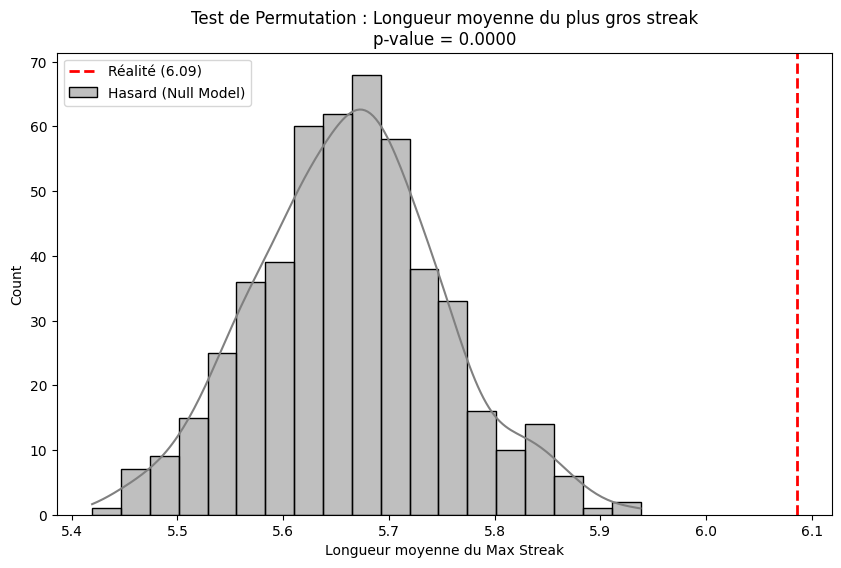

✅ CONCLUSION : Les joueurs font des séries significativement plus longues que le hasard.


In [ ]:
def calculate_max_streak(wins_series):
    """Calcule la plus longue série de victoires consécutives (1)"""
    if len(wins_series) == 0: return 0
    # Astuce vectorielle pour calculer les streaks
    change = wins_series.ne(wins_series.shift())
    counts = change.cumsum()
    # On ne garde que les victoires (1)
    streaks = wins_series.groupby(counts).sum()
    # On retourne le max (0 si que des défaites)
    return streaks.max()

# Paramètres de simulation
n_permutations = 500
results_null_model = []

print(f"Lancement de la simulation ({n_permutations} permutations)... Patience.")

# On ne prend que les joueurs avec assez de parties (>20) pour que ce soit pertinent
users_to_test = df_reg['user_id'].value_counts()
valid_users = users_to_test[users_to_test > 20].index
df_sim = df_reg[df_reg['user_id'].isin(valid_users)].copy()

real_streaks_mean = df_sim.groupby('user_id')['win'].apply(calculate_max_streak).mean()

# Simulation
simulated_means = []
for i in range(n_permutations):
    # Mélange aléatoire des résultats AU SEIN de chaque joueur
    # transform(np.random.permutation) mélange les données groupe par groupe
    shuffled_wins = df_sim.groupby('user_id')['win'].transform(np.random.permutation)
    
    # On recalcule les streaks sur ces données mélangées
    # Note: on doit reconstruire un groupby temporaire pour appliquer la fonction
    # C'est un peu lent, c'est normal
    sim_streak_avg = shuffled_wins.groupby(df_sim['user_id']).apply(calculate_max_streak).mean()
    simulated_means.append(sim_streak_avg)

# Visualisation
plt.figure(figsize=(10, 6))
sns.histplot(simulated_means, kde=True, color="gray", label="Hasard (Null Model)")
plt.axvline(real_streaks_mean, color="red", linestyle="--", linewidth=2, label=f"Réalité ({real_streaks_mean:.2f})")

# Calcul de la p-value empirique
p_val_sim = np.mean([s >= real_streaks_mean for s in simulated_means])

plt.title(f"Test de Permutation : Longueur moyenne du plus gros streak\np-value = {p_val_sim:.4f}")
plt.xlabel("Longueur moyenne du Max Streak")
plt.legend()
plt.show()

if p_val_sim < 0.05:
    print("✅ CONCLUSION : Les joueurs font des séries significativement plus longues que le hasard.")
else:
    print("❌ CONCLUSION : Les séries observées ne se distinguent pas du hasard.")